# Timeseries classification with a Transformer model

**Author:** [Theodoros Ntakouris](https://github.com/ntakouris)<br>
**Date created:** 2021/06/25<br>
**Last modified:** 2021/08/05<br>
**Description:** This notebook demonstrates how to do timeseries classification using a Transformer model.

## Introduction

This is the Transformer architecture from
[Attention Is All You Need](https://arxiv.org/abs/1706.03762),
applied to timeseries instead of natural language.

This example requires TensorFlow 2.4 or higher.

## Load the dataset

We are going to use the same dataset and preprocessing as the
[TimeSeries Classification from Scratch](https://keras.io/examples/timeseries/timeseries_classification_from_scratch)
example.

In [16]:
import os
import sys
import csv
import json
import time
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.model_selection import train_test_split

# sys.path.append(os.path.abspath(".."))
# import scripts.compensate
# import scripts.kinectImg2video
# from scripts.conpemsate_suppresser import *
# from scripts.ground_angle_analysis import ground_shoulder_angle_analyzer
# import scripts.ground_angle_analysis

In [17]:
# from google.colab import drive
# drive.mount('/content/drive')

In [18]:
l_filepath = sorted(glob.glob("/Users/kento/kuhp/research/Kinect_data/1103_act_myself/jointdata_csv/*.csv"))
# l_filepath = sorted(glob.glob("/content/drive/MyDrive/research/Kinect_data/1103_act_myself/jointdata_csv/*.csv"))

In [19]:
print(len(l_filepath))

60


In [20]:
# def read_csv(file_name):
#     l_all_data = []
#     with open(l_filepath[0], encoding='utf8') as f:
#         csvreader = csv.reader(f)
#         for row in csvreader:
#             l_all_data.append(row)
#     return l_all_data

In [21]:
#ファイル名からスコアを取得して，dfを返す関数 
def read_csv_add_score(filepath):
    df = pd.read_csv(filepath, header=None)
    #スコアの取得
    score = filepath.split("-")[1].split('.')[0]
    df['score'] = score
    return df

def interpolate_df(df):
    l = []
    for i in range(98):
        y_raw = df[i]
        length = len(y_raw)

        #rawデータを乗せる0→1のベクトルを作成する
        second_raw = np.linspace(0, 1, length)

        #新しく生成される0→1のベクトル(要素数200)
        second_new = np.linspace(0, 1, 200)

        f = interpolate.interp1d(second_raw, y_raw, kind='cubic')
        y_new = f(second_new)
        l.append(y_new)
    df_new = pd.DataFrame(l).T
    df_new['score'] = df['score'].mode()[0]
    return df_new
    
def extract_joint(df, joint_name):
    dic = joint_dict()
    joint_id = dic[joint_name]
    df_ex = df.loc[:, [joint_id, joint_id+1, joint_id+2]]
    df_ex['score'] = df['score'].mode()[0] #scoreを引き継ぐ
    return df_ex

# 内部メソッド
def joint_dict():
    dic = {'Pelvis':2,'SpineNaval':5,'SpineChest':8, 'Neck':11, 'LClavicle':14, 'LShoulder':17, 'LElbow':20, 'LWrist':23, 'LHand':26, 'LHandTip':29, 
           'LThumb':32, 'RClavicle':35, 'RShoulder':38, 'RElbow':41, 'RWrist':44, 'RHand':47, 'RHandTip':50, 'RThumb':53, 'LHip':56, 'LKnee':59, 
           'LAnkle':62, 'LFoot':65, 'RHip':68, 'RKnee':71, 'RAnkle':74, 'RFoot':77, 'Head':80, 'Nose':83, 'LEye':86, 'LEar':89, 'REye':92, 'REar':95}
    return dic

def zscore(x, axis = None):
    xmean = x.mean(axis=axis, keepdims=True)
    xstd  = np.std(x, axis=axis, keepdims=True)
    zscore = (x-xmean)/xstd
    return zscore

In [22]:
def create_pos_dataset(l_filepath, joint1_name, joint2_name):
    for filepath in l_filepath:
        df = read_csv_add_score(filepath)
        df = interpolate_df(df)
        dataset_joint1 = extract_joint(df, joint1_name)
        dataset_joint2 = extract_joint(df, joint2_name)
        
        #複数のデータ間でscoreのndarray を作成する種
        y_one = np.array([dataset_joint1['score'].mode()[0]], dtype=np.int64)
        if 'y' in locals():
            y = np.concatenate([y, y_one])
        else:
            y = y_one

        #複数のデータ間で X データセットを作成する種
        joint1 = dataset_joint1.iloc[:, 0:3].to_numpy()
        joint1 = np.expand_dims(joint1, axis=0)

        joint2 = dataset_joint2.iloc[:, 0:3].to_numpy()
        joint2 = np.expand_dims(joint2, axis=0)
        print(joint2.shape)

        X_one = joint1 - joint2

        if 'X' in locals():
            X = np.concatenate([X, X_one])
        else:
            X = X_one
            
    return X, y

In [23]:
X, y = create_pos_dataset(l_filepath, 'Neck', 'Pelvis')
condition = y == 2
y[condition] = 0
condition = y == 25
y[condition] = 1
condition = y == 3
y[condition] = 2
# y[~condition] = 0

X = zscore(X, axis=1)

(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)
(1, 200, 3)


In [24]:
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical


n_classes = len(np.unique(y))
print(n_classes)

y_categorical = to_categorical(y)
# enc = OneHotEncoder(categories="auto", sparse=False, dtype=np.float32)
# onehot_y = enc.fit_transform(y)

# x_train, x_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.01, random_state=40)
x_train, y_train = X, y_categorical

3


In [25]:
# def readucr(filename):
#     data = np.loadtxt(filename, delimiter="\t")
#     y = data[:, 0]
#     x = data[:, 1:]
#     return x, y.astype(int)


# root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

# x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
# x_test, y_test = readucr(root_url + "FordA_TEST.tsv")


In [26]:
# print(y_train)
# print(y_test)

[0 1 2]


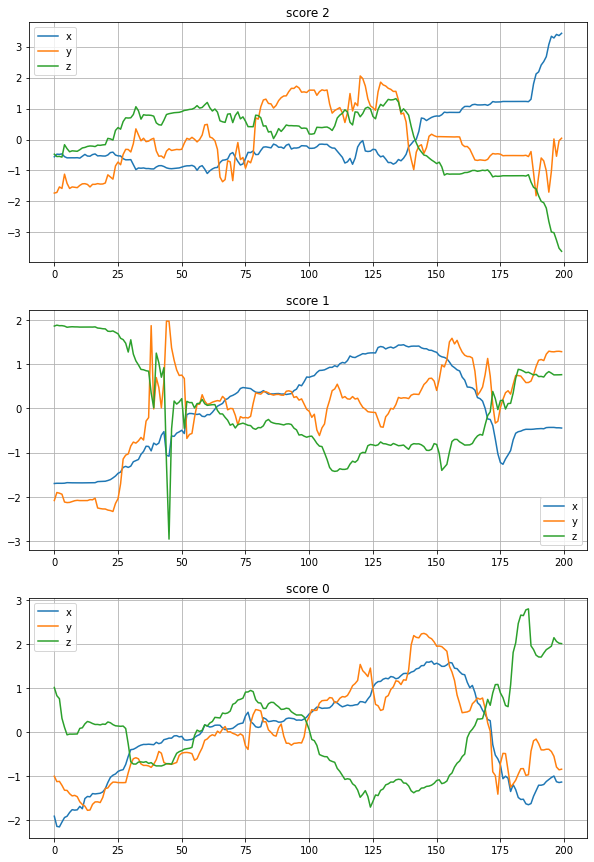

In [27]:
import matplotlib.pyplot as plt

classes = np.unique(y, axis=0)
print(classes)

fig = plt.figure(figsize=(10, 15))

# 各点のプロットを行う
for i, item in enumerate([0, 10, 20]):
    c_x_train = x_train[item]
    # print(f"class is {np.argmax(y_train[item])}")
    fig.add_subplot(3, 1, i+1)
    plt.plot(c_x_train[:, :], label=["x", "y", "z"])
    plt.title(f"score {np.argmax(y_train[item])}")
    plt.legend(loc="best")
    plt.grid()

# 各点のプロットを行う
# c_x_train = x_train[10]
# print(f"class is {np.argmax(y_train[11])}")
# fig.add_subplot(3, 1, 2)
# plt.plot(c_x_train[:, :], label=["x", "y", "z"])
# plt.legend(loc="best")
# plt.grid()


plt.show()
plt.close()

In [28]:
# print(y_train)

In [29]:
# x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
# x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))
n_classes = 3
print(n_classes)

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

# y_train[y_train == -1] = 0
# y_test[y_test == -1] = 0

3


## Build the model

Our model processes a tensor of shape `(batch size, sequence length, features)`,
where `sequence length` is the number of time steps and `features` is each input
timeseries.

You can replace your classification RNN layers with this one: the
inputs are fully compatible!

In [30]:
from tensorflow import keras
from tensorflow.keras import layers

We include residual connections, layer normalization, and dropout.
The resulting layer can be stacked multiple times.

The projection layers are implemented through `keras.layers.Conv1D`.

In [31]:

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


The main part of our model is now complete. We can stack multiple of those
`transformer_encoder` blocks and we can also proceed to add the final
Multi-Layer Perceptron classification head. Apart from a stack of `Dense`
layers, we need to reduce the output tensor of the `TransformerEncoder` part of
our model down to a vector of features for each data point in the current
batch. A common way to achieve this is to use a pooling layer. For
this example, a `GlobalAveragePooling1D` layer is sufficient.

In [32]:

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    print(x.shape)
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


## Train and evaluate

In [33]:
input_shape = x_train.shape[1:]
print(x_train.shape)
print(input_shape)

(60, 200, 3)
(200, 3)


In [ ]:


model = build_model(
    input_shape,
    head_size=256,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[128],
    mlp_dropout=0.2,
    dropout=0.2,
)

model.compile(
    # loss="sparse_categorical_crossentropy",
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    # metrics=["sparse_categorical_accuracy"],
    metrics=["categorical_accuracy"],
    # metrics=["accuracy"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)]

model.fit(
    x_train,
    y_train,
    validation_split=0,
    epochs=300,
    batch_size=1,
    # callbacks=callbacks,
)

model.evaluate(x_test, y_test, verbose=1)

Metal device set to: Apple M1
(None, 200, 3)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 3)]     0                                            
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 200, 3)       6           input_1[0][0]                    
__________________________________________________________________________________________________
multi_head_attention (MultiHead (None, 200, 3)       3843        layer_normalization[0][0]        
                                                                 layer_normalization[0][0]        
__________________________________________________________________________________________________
dropout (Dropout)               (None, 200, 3)   

2021-11-17 17:30:58.147377: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-17 17:30:58.147654: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-11-17 17:30:58.256631: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-17 17:30:58.257063: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

mnist = tf.keras.datasets.mnist

#ダウンロード終了後からの実行時間計測のために追加
import time
start_time = time.time()

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10, activation='softmax')

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# モデルのインスタンスを作成
model = MyModel()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

@tf.function
def test_step(images, labels):
  predictions = model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

EPOCHS = 5

for epoch in range(EPOCHS):
  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         test_loss.result(),
                         test_accuracy.result()*100))

  # 次のエポック用にメトリクスをリセット
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

# 計測した結果を出力
tat_time = time.time() - start_time
print ("実行時間:{0}".format(tat_time) + "[秒]")

11501568/11490434 [==============================] - 1s 0us/step


2021-11-17 17:15:03.965230: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-17 17:15:03.965956: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


# SaveModel

In [ ]:
# num_head = 1, num_block =1
# model.save_weights('/content/drive/MyDrive/research/code/transformer/model_weight.hdf5')

# Extract model weights

In [ ]:
model.summary()

In [ ]:
from keras.models import Model
layer_name = 'multi_head_attention_10'
hidden_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

In [ ]:
hidden_output = hidden_layer_model.predict(x_train)
hidden_output.shape

In [ ]:
weights = model.get_layer(layer_name).get_weights()
# print(weights)
print(type(weights))
print(len(weights))
print(weights[0].shape)
print(weights[0][0].shape)

In [ ]:
print(hidden_output[0, :, :])

## Conclusions

In about 110-120 epochs (25s each on Colab), the model reaches a training
accuracy of ~0.95, validation accuracy of ~84 and a testing
accuracy of ~85, without hyperparameter tuning. And that is for a model
with less than 100k parameters. Of course, parameter count and accuracy could be
improved by a hyperparameter search and a more sophisticated learning rate
schedule, or a different optimizer.

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred = model.predict(x_train)
# print(pred)
# print(y_test)
test_seed = np.argmax(y_train, axis=1)
onehot_pred_seed = np.argmax(pred, axis=1)
onehot_pred = np.zeros((len(y_train), n_classes))

for i in range(len(y_train)):
    onehot_pred[i, onehot_pred_seed[i]] = 1
print(onehot_pred)

plt.figure()
# sns.heatmap(pred)

labels = sorted(list(set(test_seed)))
c_mtx = confusion_matrix(test_seed, onehot_pred_seed)
print(c_mtx)
df_cmx = pd.DataFrame(c_mtx, index=labels, columns=labels)

plt.figure(figsize = (10,7))
sns.heatmap(df_cmx, annot=True, cmap='Blues')
plt.show()

In [ ]:


pred = model.predict(x_test)
mask = pred[:, 0] > 0.7
print(mask)
prediction = np.ones(len(pred))
prediction[mask] = int(0)
print(prediction)
print(y_test)

# confusion_matrix(y_test, prediction)

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, pred[:, 1])
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
# plt.savefig('data/dst/sklearn_roc_curve.png')
